# Anscombe's quartet

Anscome’s Quartet  ["Graphs in Statistical Analysis" Anscombe, F. J. (1973)](https://www.sjsu.edu/faculty/gerstman/StatPrimer/anscombe1973.pdf) is a set of four distinct data sets each consisting of 11 `(x,y)` pairs where each dataset produces the same summary statistics: 

| Property | Value | Accuracy |
| :- |:-------------: | -: |
| Mean of x : $\overline{x}$ | 9 | exact |
| Sample variance of x : $\sigma^{2}$ | 11 | exact |
| Mean of y : $\overline{y}$ |	7.50 | to 2 decimal places |
| Sample variance of y : $\sigma^{2}$ | 4.125 | ±0.003 |
| Correlation between x and y |	0.816 | to 3 decimal places |
| Linear regression line | $${y=3.00+0.500x}$$ |	to 2 and 3 decimal places, respectively |
| Coefficient of determination of the linear regression : $R^{2}$ | 0.67 |	to 2 decimal places |


Along this notebook we will be computing statics over the Anscombe's quartet data set and visualizing it.  

## Reading the data
We will first load Anscombe data set using pandas [`read_csv(...)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method. The dataset consists on 44 rows and 3 columns corresponding to `x`,`y` pairs and a `dataset` field indicating the data set index (`I/II/III/IV`) the pair beolongs to. Let's take a look at it:

In [1]:
import pandas as pd          # import pandas
import seaborn as sns        # import seaborn, we will be using anscombe dataset and sns.FacetGrid

pd.set_option("max_rows", 8)              # only display up to 8 rows when printing dataframes (reduce visual clutter)
anscome_df = sns.load_dataset("anscombe") # load anscombe dataset from seaborn
anscome_df['x'] = anscome_df['x'].astype(float)
anscome_df['y'] = anscome_df['y'].astype(float)
anscome_df                                # check data has been loaded

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
...,...,...,...
40,IV,19.0,12.50
41,IV,8.0,5.56
42,IV,8.0,7.91
43,IV,8.0,6.89


## Visualizing data sets

In order to visually inspect the Anscombe dataset, let's plot each point cloud using scatterplots from [matplotlib](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.scatter.html) and multi-plot grids from [seaborn](https://seaborn.pydata.org/tutorial/axis_grids.html). Despite data share the aforementioned statistics, notice how different the plots are from each other.

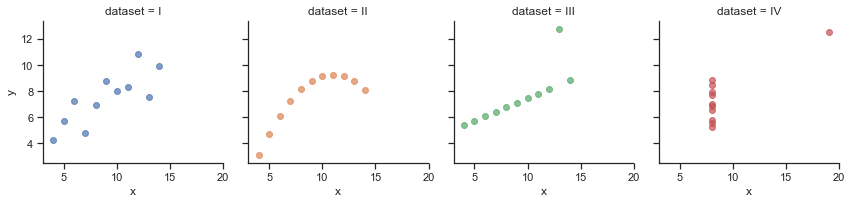

In [2]:
import matplotlib.pyplot as plt  # import pyplot to create scatter plots
sns.set(style="ticks")

g = sns.FacetGrid(anscome_df, col="dataset", hue="dataset") # define a grid of plots. Each element shows a different memeber from the quartet in a different column and color
g.map(plt.scatter, "x", "y", alpha=.7)                      # render scatterplots

## Computing statistics
Now, lets verify statics are shared among all data partitions.

In [3]:
anscome_dataset_labels = anscome_df['dataset'].unique() # labels for each dataset

# First, compute mean
anscome_mean_of_xy = {q: anscome_df[anscome_df['dataset'] == q].mean() for q in anscome_dataset_labels}

# Second, compute variances 
anscome_var_of_xy  = {q: anscome_df[anscome_df['dataset'] == q].var() for q in anscome_dataset_labels}

# Third, compute correlation between x and y
anscome_corr_of_xy = {q: anscome_df[anscome_df['dataset'] == q]['x'].corr(anscome_df[anscome_df['dataset'] == q]['y']) for q in anscome_dataset_labels}

In [4]:
# Show statistics
pd.concat([pd.DataFrame.from_dict(anscome_mean_of_xy).rename({"x": "Mean of x", "y": "Mean of y"}),
           pd.DataFrame.from_dict(anscome_var_of_xy).rename({"x": "Variance of x", "y": "Variance of y"}),
           pd.DataFrame({k: [v] for k, v in anscome_corr_of_xy.items()}).rename({0: "Correlation between x and y"})])\
          .style.set_precision(3).set_caption("Anscombe's quartet statistics")

,I,II,III,IV
dataset,(5.878118300992534+8.251213577625485j),nan,nan,nan
Mean of x,(9+0j),9.000,9.000,9.000
Mean of y,(7.500909090909093+0j),7.501,7.500,7.501
Variance of x,(11+0j),11.000,11.000,11.000
Variance of y,(4.127269090909091+0j),4.128,4.123,4.123
Correlation between x and y,(0.81642051634484+0j),0.816,0.816,0.817


## Linear regression
Finally, we perform a linear regression over each point set. We will be using the [`LinearRegression().fit(X,y)`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) method from [scikit-learn](https://scikit-learn.org/stable/index.html)

In [5]:
from sklearn.linear_model import LinearRegression

# Fit the data. Notice
reg_of_xy = {q: LinearRegression().fit(anscome_df[anscome_df['dataset'] == q]['x'].values.reshape(-1, 1),
                                       anscome_df[anscome_df['dataset'] == q]['y'].values.reshape(-1, 1)) 
                                       for q in anscome_dataset_labels}

# Compute the coefficient of determination R^2 of the prediction
coef_of_xy = {q: reg_of_xy[q].score(anscome_df[anscome_df['dataset'] == q]['x'].values.reshape(-1, 1),
                                    anscome_df[anscome_df['dataset'] == q]['y'].values.reshape(-1, 1)) 
                                    for q in anscome_dataset_labels}

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_base.py:547: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [6]:
# Get and show coeficients of linear fits
linear = {q: reg_of_xy[q].coef_      for q in anscome_dataset_labels}
const  = {q: reg_of_xy[q].intercept_ for q in anscome_dataset_labels}
print("Linear fits for each dataset")
for q in anscome_dataset_labels:
    print('y={:.3}x+{:.3} / R2={:.3} : {}'.format(linear[q].flatten()[0],const[q].flatten()[0],coef_of_xy[q],q))

Linear fits for each dataset
y=0.5x+3.0 / R2=0.667 : I
y=0.5x+3.0 / R2=0.666 : II
y=0.5x+3.0 / R2=0.666 : III
y=0.5x+3.0 / R2=0.667 : IV


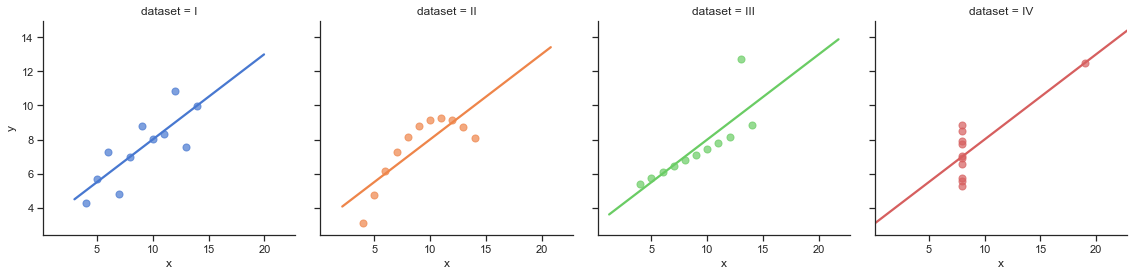

In [7]:
# Show the results of a linear regression within each dataset
sns.set(style="ticks")
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=anscome_df,
           col_wrap=4, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": .7})

## Bonus: DataSaurus
As a final bonus, let's look at the DataSaurus dataset from the paper ["Same Stats, Different Graphs: Generating Datasets with Varied Appearance and Identical Statistics through Simulated Annealing" Justin Matejka and George Fitzmaurice (2017)](https://dl.acm.org/doi/pdf/10.1145/3025453.3025912). Each dataset has the same summary statistics to two decimal places.

In [8]:
# Read data from csv and preview
datasaurus_df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/1_Anscombe/data/DatasaurusDozen.csv")
datasaurus_df

,dataset,x,y
0,dino,55.384600,97.179500
1,dino,51.538500,96.025600
2,dino,46.153800,94.487200
3,dino,42.820500,91.410300
...,...,...,...
1700,slant_down,95.593416,33.234129
1701,slant_down,52.772288,99.613472
1702,slant_down,53.178614,98.603861
1703,slant_down,37.627053,93.060673


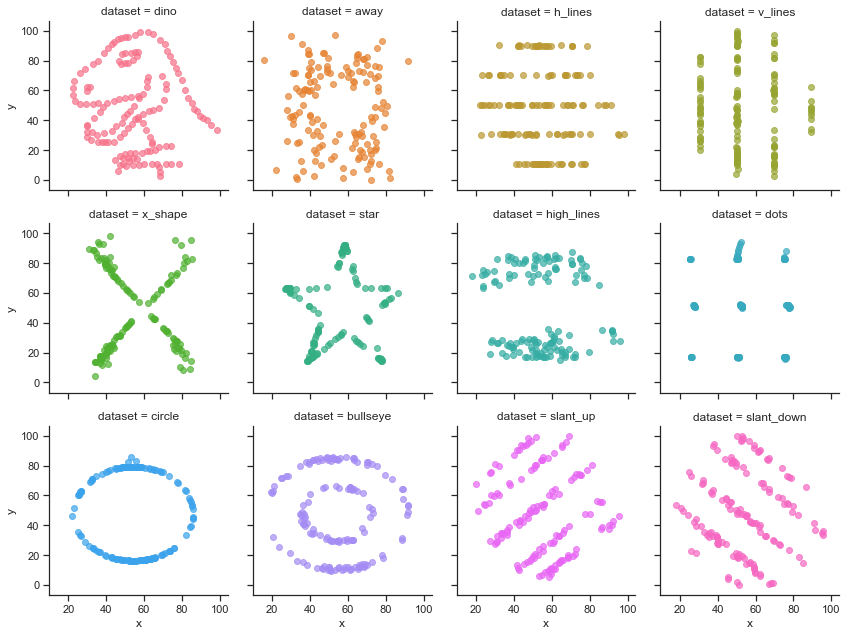

In [9]:
# Plot each dataset
g = sns.FacetGrid(datasaurus_df, col_wrap=4, col="dataset", hue="dataset") # define a grid of plots. Each element shows a different memeber from the quartet in a different column and color
g.map(plt.scatter, "x", "y", alpha=.7)                                     # render scatterplots

In [10]:
dataset_datasaurus_labels = datasaurus_df['dataset'].unique() # labels for each dataset

# First, compute mean
datasaurus_mean_of_xy = {q: datasaurus_df[datasaurus_df['dataset'] == q].mean() for q in dataset_datasaurus_labels}

# Second, compute variances 
datasaurus_var_of_xy  = {q: datasaurus_df[datasaurus_df['dataset'] == q].var() for q in dataset_datasaurus_labels}

# Third, compute correlation between x and y
datasaurus_corr_of_xy = {q: datasaurus_df[datasaurus_df['dataset'] == q]['x'].corr(datasaurus_df[datasaurus_df['dataset'] == q]['y']) for q in dataset_datasaurus_labels}

In [11]:
# Show statistics
pd.concat([pd.DataFrame.from_dict(datasaurus_mean_of_xy).rename({"x": "Mean of x", "y": "Mean of y"}),
           pd.DataFrame.from_dict(datasaurus_var_of_xy).rename({"x": "Variance of x", "y": "Variance of y"}),
           pd.DataFrame({k: [v] for k, v in datasaurus_corr_of_xy.items()}).rename({0: "Correlation between x and y"})])\
          .style.set_precision(3).set_caption("DataSaurus statistics")

,dino,away,h_lines,v_lines,x_shape,star,high_lines,dots,circle,bullseye,slant_up,slant_down
dataset,0.14084507042253522j,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Mean of x,(54.26327323943664+0j),54.266,54.261,54.270,54.260,54.267,54.269,54.260,54.267,54.269,54.266,54.268
Mean of y,(47.832252816901374+0j),47.835,47.830,47.837,47.840,47.840,47.835,47.840,47.838,47.831,47.831,47.836
Variance of x,(281.069987591761+0j),281.227,281.095,281.232,281.231,281.198,281.122,281.157,280.898,281.207,281.194,281.124
Variance of y,(725.5159610042118+0j),725.750,725.757,725.639,725.225,725.240,725.763,725.235,725.227,725.533,725.689,725.554
Correlation between x and y,(-0.06447185270095165+0j),-0.064,-0.062,-0.069,-0.066,-0.063,-0.069,-0.060,-0.068,-0.069,-0.069,-0.069
